## NLP - How to read a text corpus into the Spark environment (Framework)

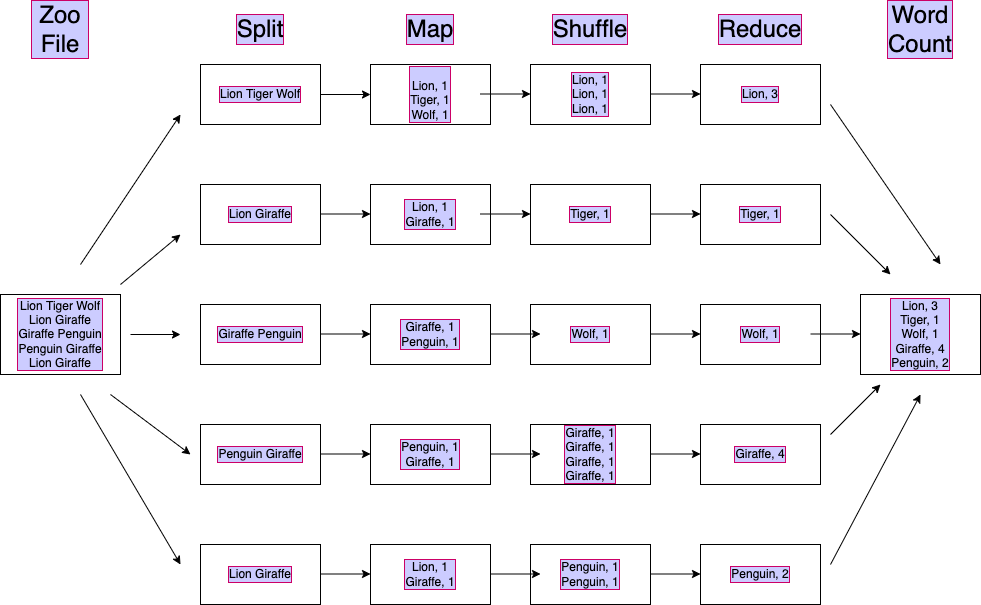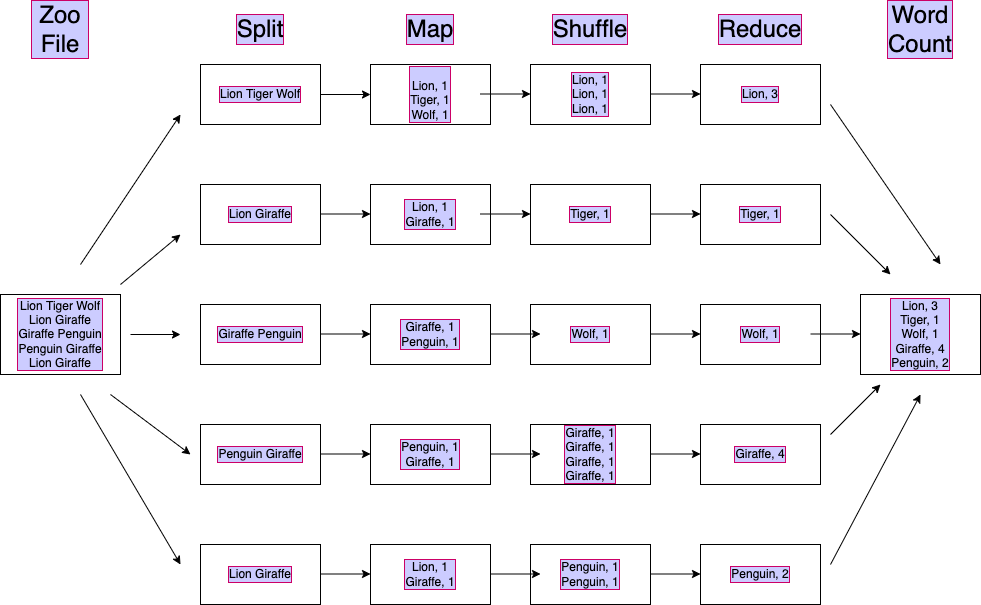

### Initialize SparkContext

- First, import the `pyspark` module into this Python environment and initialize a SparkContext with the conventional name `sc`
- SparkContext should be local (standalone cluster)

In [1]:
# Start a local SparkContext
import pyspark
sc = pyspark.SparkContext('local[*]', 'word count')

To test our code, start with a single text file, `'hamlet.txt'`

In [2]:
# Set a path variable for data 
file = 'hamlet.txt'
file

'hamlet.txt'

## Read and Split Text File Contents into RDD - `sc.textFile()`

We will read the text file into Spark RDDs by using the `sc.textFile()` method. We'll load the data from the text file into an RDD called `lines`. 

The documentation the `textFile` method in PySpark can be found [here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.SparkContext.textFile.html) and more in-depth documentation on RDDs can be found [here](https://spark.apache.org/docs/latest/rdd-programming-guide.html).

The `textFile(path)` method reads a text file from the HDFS/local file system/any Hadoop supported file system, into the number of partitions specified and returns it as an RDD of strings.

In [3]:
# Read the text file into an RDD using sc.textFile()
lines = sc.textFile(file) #None
lines

hamlet.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

The text file has been written in a "line-by-line" manner into the RDD. We can access any given entry using simple indexing. 

In order to view the contents of the RDD, we will use the `RDD.collect()` method since calling the RDD by name will not return the contents, only the object type and relevant information due to lazy loading. 

Print a few sample lines from the `lines` RDD.

In [4]:
#Print a few sample lines from the lines RDD
print(lines.collect()[300])
print(lines.collect()[900])

    His further gait herein, in that the levies,
    And in the porches of my ears did pour


Similarly, we can also print the whole document line by line if we loop over the result of `collect()`.

Print the complete Hamlet from the `lines` RDD.

In [5]:
# Print the text, line-by-line
# This will output the whole of hamlet text, one line at a time. 
for line in lines.collect():
    print(line)


1604


THE TRAGEDY OF HAMLET, PRINCE OF DENMARK


by William Shakespeare



Dramatis Personae

  Claudius, King of Denmark.
  Marcellus, Officer.
  Hamlet, son to the former, and nephew to the present king.
  Polonius, Lord Chamberlain.
  Horatio, friend to Hamlet.
  Laertes, son to Polonius.
  Voltemand, courtier.
  Cornelius, courtier.
  Rosencrantz, courtier.
  Guildenstern, courtier.
  Osric, courtier.
  A Gentleman, courtier.
  A Priest.
  Marcellus, officer.
  Bernardo, officer.
  Francisco, a soldier
  Reynaldo, servant to Polonius.
  Players.
  Two Clowns, gravediggers.
  Fortinbras, Prince of Norway.  
  A Norwegian Captain.
  English Ambassadors.

  Getrude, Queen of Denmark, mother to Hamlet.
  Ophelia, daughter to Polonius.

  Ghost of Hamlet's Father.

  Lords, ladies, Officers, Soldiers, Sailors, Messengers, Attendants.





SCENE.- Elsinore.


ACT I. Scene I.
Elsinore. A platform before the Castle.

Enter two Sentinels-[first,] Francisco, [who paces up and down
at his p

Great, now that the complete text file is in a `lines` RDD, we can easily use the map function to break it down further into individual words and parallelize it accordingly. 

__Note: Parallelization is handled by the Spark environment according to available infrastructure and doesn't need any further configuration__.

## The Map Step

Currently, we have an RDD where each record is a line of text. What we need to do next is:

* Split each line into words
  * We might call these `w1, w2, . . . , wn`
* Clean up the words based on any issues we notice
* Map the words onto a tuple containing the word and the number `1`
  * The tuples will look like this: `(w1, 1), (w2, 1), . . . ,(wn, 1)`

Then later on we will use the Reduce step to combine all of those numbers into word counts.

### Spark Mapping Functions

Previously, we saw that:

* `map(func)` returns a new distributed dataset formed by passing each element of the source through a function `func`.
* `flatMap(func)` maps each input item to 0 or more output items (so `func` should return a seq rather than a single item).
* `flatMap()` breaks the output of a lambda function into individual RDD elements (as opposed to

### Split Each Line into Words

* Use `RDD.flatMap()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.flatMap.html)) to split the lines by whitespace and collect into one flat RDD.
* The transformation is defined in the lambda expression, where the input `x` is defined as producing the result of `x.split()`.
* Use the `RDD.take(n)` method ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.take.html)) to pick `10` words from the top of the sequence, in order to view the results of our work so far. map).

In [7]:
# split the lines into words based on whitespace and show ten elements from the top 
words = lines.flatMap(lambda x: x.split())
words.take(10)

['1604',
 'THE',
 'TRAGEDY',
 'OF',
 'HAMLET,',
 'PRINCE',
 'OF',
 'DENMARK',
 'by',
 'William']

### Create a Tuple of (Word, 1)

* Map each word to a tuple of (word, 1), which will be our (key, value) pair later on.
  * (Yes, just the number 1 for each word. Eventually this numbers will be added together.)
* Use `RDD.map` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.map.html))
* Use `RDD.take(n)` to view 10 elements

# Use a lambda function with map to add a 1 to each word and output a tuple
# (word, 1) - Take ten elements
tuples = words.map(lambda x: (x, 1))
tuples.take(10)

It appears that we have a mixture of words in capital letters as well as lowercase letters. If we count this way, `"THE"` and `"the"` would be considered two separate words due to case sensitivity.

### Cleaning: Normalize Case

One typical way to normalize different cases in strings is just to make them all lowercase.

Modify the map function above to change all the words to lowercase using a `.lower()` inside the lambda function. Then use `RDD.take(n)` to view 10 elements.

In [9]:
# Change the words in words tuples to lowercase - take 10 elements 
tuples_lowercase = words.map(lambda x: (x.lower(), 1))
tuples_lowercase.take(10)

[('1604', 1),
 ('the', 1),
 ('tragedy', 1),
 ('of', 1),
 ('hamlet,', 1),
 ('prince', 1),
 ('of', 1),
 ('denmark', 1),
 ('by', 1),
 ('william', 1)]

## The Reduce Step

Ok, now we think we have data that is prepared for the next step.

### Aggregate Word Counts

Our goal is to aggregate all of those `1`s to find the word count.

The Reduce step's argument is a pair consisting of a key and its list of associated values as the pairs created above. The output of the Reduce function is a sequence of zero or more key-value pairs. These key-value pairs can be of a type different from those sent from Map tasks to Reduce tasks, but often they are the same type.

We will refer to the application of the Reduce step to a single key and its associated list of values as a reducer.

* Use `RDD.reduceByKey()` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html)) to add up all the words.
* For this method, the lambda has two arguments (`x` and `y`) instead of just `x`. We have two variables here because we're talking about a binary *reduce* function, which must in addition be commutative and associative.
* The new (key, value) pairs would have the word as a key and the number of occurrences as a value. 

In [10]:
# Use reduceByKey with lowercase tuples to add all values under same keys - take 10
word_count = tuples_lowercase.reduceByKey(lambda x,y: x+y)
word_count.take(10)

[('1604', 1),
 ('tragedy', 1),
 ('of', 670),
 ('prince', 2),
 ('denmark', 10),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('claudius,', 2),
 ('king', 43),
 ('officer.', 3)]

Hmm, there is still something off about this data. Specifically, we have some words containing punctuation, so that `"officer"` and `"officer."` are treated as different words.

### Cleaning: Remove Punctuation

Let's go back to the cleaning step (Map), then Reduce again so that the duplicates are grouped together.

Apply another `.map` to our aggregated data so that the words are stripped of punctuation. Currently when we write `lambda x:` that `x` contains a (word, count) tuple, so make sure you apply the string transformation to `x[0]` and return a tuple containing the transformed string as well as `x[1]`.

In other words, if `x` is `('officer.', 3)` then your lambda function should return `('officer', 3)`.

***Hint:*** in case you don't remember, this is an example of how you would remove punctuation from a single string:

```python
import string
'claudius,'.strip(string.punctuation)
# 'claudius'
```

In [13]:
# Change the words in word count tuples to remove punctuation - take 10
import string
punc_removed = word_count.map(lambda x: (x[0].strip(string.punctuation), x[1]))
punc_removed.take(10)

[('1604', 1),
 ('tragedy', 1),
 ('of', 670),
 ('prince', 2),
 ('denmark', 10),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('claudius', 2),
 ('king', 43),
 ('officer', 3)]

### Aggregate Word Counts Again

Presumably we have some duplicate words again now that punctuation has been removed. Use `reduceByKey` again to aggregate their counts.

In [14]:
# Reduce again using words with puctuation removed - take 10
word_count = punc_removed.reduceByKey(lambda x,y: x+y)
word_count.take(10)

[('1604', 1),
 ('tragedy', 3),
 ('of', 675),
 ('prince', 5),
 ('denmark', 23),
 ('shakespeare', 1),
 ('dramatis', 1),
 ('king', 196),
 ('officer', 3),
 ('son', 22)]

### Filter Rare Words

Now we are going beyond just getting a word count, into the other kinds of Map steps that can occur.

In addition to aggregating, the Map step can also be used for filtering.

Let's use `RDD.filter(func)` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.filter.html)) to remove all words that appear less frequently than some threshold value.

* `func` in this case is a lambda function that takes in `x` (a tuple of (word, count)) and returns True or False.
  * In this case, `x[1]` is what you care about, since it contains the word count
* `func` should return True if we want to keep the word and False if we want to filter it out.
* Let's say for this task you want to filter out any word that appears less than `5` times.
  * This NLP approach can be useful to identify common topics between documents, where very rare words can be misleading.

In [15]:
# Remove all rare words with frequency less than 5 - take 10 
freq_words = word_count.filter(lambda x:  x[1] >= 5 )
freq_words.take(10)

[('of', 675),
 ('prince', 5),
 ('denmark', 23),
 ('king', 196),
 ('son', 22),
 ('polonius', 36),
 ('horatio', 47),
 ('courtier', 10),
 ('guildenstern', 30),
 ('gentleman', 16)]

### Filter to Keep Only Stopwords

Add a filtering step to retain only words included in a list of stopwords.

For this task, the stopwords are:

```python
['the','a','in','of','on','at','for','by','I','you','me']
```

Once again, use the `filter` function and pass in a lambda function. This time you want to use `x[0]` (the word) in your conditional statement.

In [16]:
# Filter to keep only stopwords
stopword_list = ['the','a','in','of','on','at','for','by','i','you','me'] 
stopwords = freq_words.filter(lambda x:  x[0] in stopword_list) 
stopwords.collect()

[('of', 675),
 ('at', 87),
 ('i', 577),
 ('in', 434),
 ('you', 554),
 ('me', 234),
 ('for', 250),
 ('on', 128),
 ('the', 1090),
 ('by', 111),
 ('a', 558)]

### Filter to Remove Stopwords

Modify the filter operation above to keep all the words found in the text **except** the stop words. 

Removing stop words can be useful in recognizing the topic of a document.

In [17]:
# Modify above filter to remove stopwords
keep_words = freq_words.filter(lambda x:  x[0] not in stopword_list) 
keep_words.take(10)

[('prince', 5),
 ('denmark', 23),
 ('king', 196),
 ('son', 22),
 ('polonius', 36),
 ('horatio', 47),
 ('courtier', 10),
 ('guildenstern', 30),
 ('gentleman', 16),
 ('two', 26)]

### Find the Top 10

Now that we have an RDD containing only keep words (i.e. containing no stopwords), use `RDD.takeOrdered` ([documentation here](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.takeOrdered.html)) to take the top 10 key-value pairs by word frequency.

You'll need to use the `key` argument in order to sort by the count, and also use `-x[1]` to order by highest to lowest

In [18]:
# Take top 10 key-value pairs by frequency
output = keep_words.takeOrdered(10, key=lambda x: -x[1])
output

[('and', 964),
 ('to', 742),
 ('my', 520),
 ('it', 419),
 ('that', 389),
 ('ham', 358),
 ('is', 346),
 ('not', 315),
 ('his', 304),
 ('this', 300)]

## Putting It All Together 

Combine the above code as a function called `top_10_words` that splits, cleans, combines, and filters the words in a text file before returning the 10 most frequent words and their frequencies.

Then pass in three works of Shakespeare (`'romeandjuliet.txt'`, `'hamlet.txt'`, and `'othello.txt'`) and observe the results. Repeat the same exercise for three works of Jane Austen (`'senseandsensibility.txt'`, `'prideandprejudice.txt'` and `'emma.txt'`). 

> Can you recognize the writing styles or topics of these authors based on their word frequencies?

> What can you do to improve the author recognition ability?

In [19]:
# Create a function for word count that takes in a file name and stop wordlist to perform above tasks
def top_10_words(sc, file_name, stopword_list):
    
    # Load from file on disk into RDD
    text_file = sc.textFile(file_name)
    
    # Split into words
    words = text_file.flatMap(lambda x: x.split())
    
    # Clean word tuples (lowercase and remove punctuation all at once this time)
    clean_words = words.map(lambda x: (x.lower().strip(string.punctuation), 1))
    
    # Reduce to get word counts
    word_counts = clean_words.reduceByKey(lambda x,y: x+y)
    
    # Filter out words that appear fewer than 5 times
    # (this is not really needed for this task, but could help improve
    # efficiency in some contexts)
    frequent_words = word_counts.filter(lambda x: x[1] >= 5)
    
    # Filter out words in stopword_list
    keep_words = frequent_words.filter(lambda x:  x[0] not in stopword_list)
    
    # Return the top 10
    return keep_words.takeOrdered(10, key=lambda x: -x[1])

In [22]:
# Test out the function with Shakespeare's texts

print("Romeo and Juliet")
print(top_10_words(sc, 'romeoandjuliet.txt', stopword_list))
print("Hamlet")
print(top_10_words(sc, 'hamlet.txt', stopword_list))
print("Othello")
print(top_10_words(sc, 'othello.txt', stopword_list))

Romeo and Juliet
[('and', 754), ('to', 625), ('my', 378), ('is', 371), ('that', 361), ('thou', 277), ('not', 274), ('this', 270), ('with', 255), ('it', 254)]
Hamlet
[('and', 964), ('to', 742), ('my', 520), ('it', 419), ('that', 389), ('ham', 358), ('is', 346), ('not', 315), ('his', 304), ('this', 300)]
Othello
[('and', 825), ('to', 663), ('my', 452), ('that', 389), ('it', 343), ('iago', 341), ('not', 334), ('is', 319), ('this', 276), ('your', 237)]


In [23]:
# Test out the function with Austen texts

print("Sense and Sensibility")
print(top_10_words(sc, 'senseandsensibility.txt', stopword_list))
print("Pride and Prejudice")
print(top_10_words(sc, 'prideandprejudice.txt', stopword_list))
print("Emma")
print(top_10_words(sc, 'emma.txt', stopword_list))

Sense and Sensibility
[('to', 4228), ('and', 3601), ('her', 2563), ('was', 1871), ('it', 1768), ('she', 1610), ('that', 1415), ('be', 1319), ('not', 1275), ('as', 1248)]
Pride and Prejudice
[('to', 4204), ('and', 3593), ('her', 2211), ('was', 1847), ('she', 1694), ('that', 1586), ('it', 1519), ('not', 1444), ('he', 1323), ('his', 1269)]
Emma
[('to', 5202), ('and', 4535), ('was', 2367), ('her', 2356), ('it', 2244), ('she', 2207), ('not', 2108), ('be', 1970), ('that', 1715), ('he', 1697)]


# Writing styles interpretation

> **The most noticeable difference in the styles is that Austen's top words include "her" and "she", while Shakespeare's top words do not. This aligns with our general understanding of these authors**
> 
> **In order to improve this, we might want to expand the list of stopwords. Right now the top two words for all texts are "and", and "to", so those words aren't telling us much**ch.
""";

In [24]:
sc.stop()